In [1]:
# Don't look at this notebook through a peephole
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from astropy.table import Table
r=Table.read('../data/Cluster-narrow.hdf5', format='hdf5')
r.info()

<Table length=125240>
           name            dtype    unit                                             description                                           n_bad
------------------------- ------- -------- ----------------------------------------------------------------------------------------------- -----
                source_id   int64                                                                                                              0
                       ra float64      deg                                                                                 Right ascension     0
                      dec float64      deg                                                                                     Declination     0
                     pmra float64 mas / yr                                                      Proper motion in right ascension direction     0
                    pmdec float64 mas / yr                                                          Proper m

In [28]:
from astropy.io import misc
dist_fit = misc.fnunpickle("../data/dist_fit.dat")
pmra_fit = misc.fnunpickle("../data/pmra_fit.dat")
pmdec_fit = misc.fnunpickle("../data/pmdec_fit.dat")
#pmdec_fit = misc.fnunpickle("../data/rcrit_fit.dat")

print(dist_fit)
print(pmra_fit)
print(pmdec_fit)
#print(rcrit_fit)

Model: Gaussian1D
Name: cluster
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev      
    ------------------ ----------------- ------------------
    199.75311365282377 2.262249619022899 0.1465050787064225
Model: Gaussian1D
Name: cluster
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ----------------- ------------------- ------------------
    92.04565858169337 -0.6361042080842684 0.1487169163435591
Model: Gaussian1D
Name: cluster
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- ------------------- -------------------
    85.78815081701164 -1.1452565101465122 0.11978877136953692


In [4]:
%%time
import numpy as np

# Member Criteria reproduced
dist_center = dist_fit.parameters[1]
dist_extent = dist_fit.parameters[2] *2
pmra_center = pmra_fit.parameters[1]
pmdec_center = pmdec_fit.parameters[1]
pmra_extent = pmra_fit.parameters[2] *2
pmdec_extent = pmdec_fit.parameters[2]*2

member_pmdata = [(pmra-pmra_center)**2/pmra_extent**2 + (pmdec-pmdec_center)**2/pmra_extent**2 < 1 for pmra,pmdec in zip(r['pmra'],r['pmdec']) ]
print("Count of stars identified by proper motion criteria only: ", np.count_nonzero(member_pmdata))

member_all = [(pmra-pmra_center)**2/pmra_extent**2 + 
              (pmdec-pmdec_center)**2/pmra_extent**2 +
              (dist-dist_center)**2/dist_extent**2 < 1 for pmra,pmdec,dist in zip(r['pmra'],r['pmdec'],r['r_med_geo']/1000) ]
print("Count of stars identified by combined criteria: ", np.count_nonzero(member_all))

Count of stars identified by proper motion criteria only:  7248
Count of stars identified by combined criteria:  2961
CPU times: user 6.93 s, sys: 0 ns, total: 6.93 s
Wall time: 6.92 s


125240 0 <class 'astropy.table.column.MaskedColumn'> 125240
125240 0 <class 'astropy.table.column.MaskedColumn'> 53007
125240 0 <class 'astropy.table.column.MaskedColumn'> 53007
Members with absolute mags:
2603
Members with apparent mags:
2961


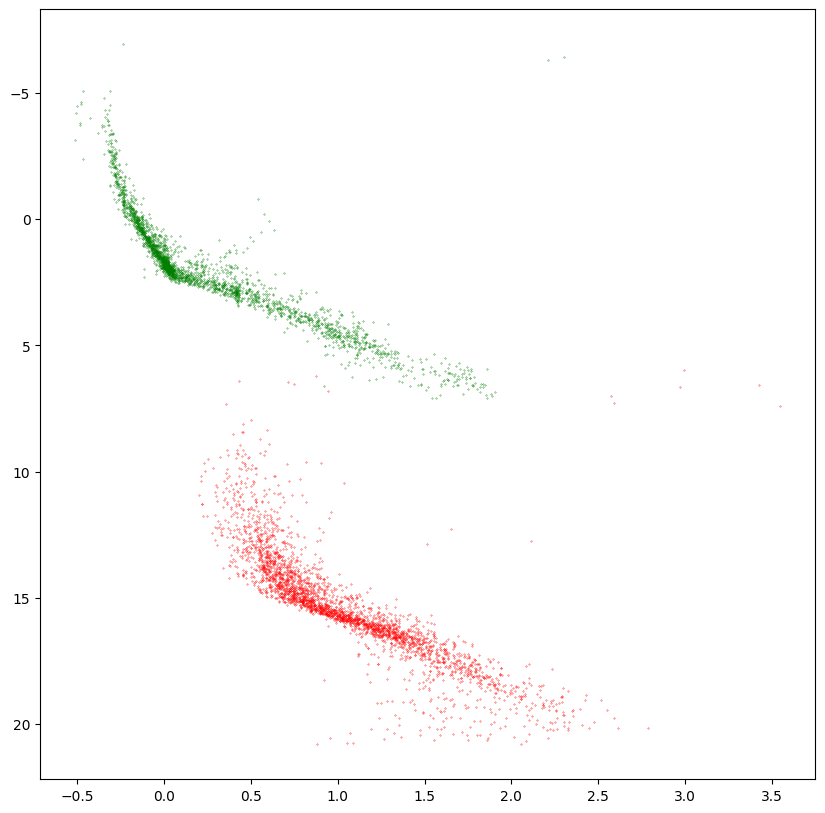

In [15]:
import matplotlib.pyplot as plt

# Calculate extinctions and absolute magnitudes for everybody by using bailer jones distance
# m - M = -5 + 5 log(d)
# rearranging
# M = 5 - 5log(d) + m

# m here is mag we would see without exinction
# m_obs is the magnitude with extinction
# A_0 is positive
#
# m_obs = m + A_0
# m = m_obs - A_0
# M = 5 - 5 log(d) + m_obs - A_0
#
# Assuming I got all that right to how gaia and astronomy work (LOL!)
#



absmag_g = 5.0 - 5.0*np.log10(r['r_med_geo']) + r['phot_g_mean_mag']
print(len(absmag_g),np.count_nonzero(np.isnan(absmag_g)), type(absmag_g), absmag_g.count())

#absmag_g = 5 - 5*np.log10(r['distance_gspphot']) + r['phot_g_mean_mag']
absmag_g_ext = absmag_g - r['ag_gspphot']
print(len(absmag_g_ext),np.count_nonzero(np.isnan(absmag_g_ext)), type(absmag_g_ext), absmag_g_ext.count())

bp_rp_ext = r['bp_rp'] -  r['ebpminrp_gspphot']
print(len(bp_rp_ext),np.count_nonzero(np.isnan(bp_rp_ext)), type(bp_rp_ext), bp_rp_ext.count())


mag_g_members = np.ma.array(r['phot_g_mean_mag'], mask=np.logical_not(member_all))
#print(mag_g_members.count(), len(r['phot_g_mean_mag']), np.count_nonzero(np.logical_not(member_all)))
absmag_g_members = np.ma.array(absmag_g, mask=np.logical_not(member_all))
absmag_g_ext_members = np.ma.array(absmag_g_ext, mask=np.logical_not(member_all))

bp_rp_members = np.ma.array(r['bp_rp'], mask=np.logical_not(member_all))
#print(bp_rp_members.count(), len(r['bp_rp']), np.count_nonzero(np.logical_not(member_all)))
bp_rp_ext_members = np.ma.array(bp_rp_ext, mask=np.logical_not(member_all))

print("Members with absolute mags:")
print(np.count_nonzero(absmag_g_ext_members.compressed()))

print("Members with apparent mags:")
print(np.count_nonzero(mag_g_members.compressed()))


# Plot absolute mag and unadjusted-for-extinction color (choose same color as the paper)
plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
#plt.scatter(bp_rp_ext_members, absmag_g_members, 0.07, color="blue")
#plt.scatter(bp_rp_members, absmag_g_ext_members, 0.07, color="green")
plt.scatter(bp_rp_ext_members, absmag_g_ext_members, 0.07, color="green")
figure = plt.gcf()
axes = figure.gca()
axes.invert_yaxis()
plt.show()

In [16]:
#Write a function
# Input is log10(age), metalicity, distance, extinction
# Output is points at all valid EEPS (those that don't return nan) in an astropy table with colums 'G' and 'BP-RP' both in mags
# EEPS can possibly run from 0 to 1710
import astropy.units as u


def get_isochrone(age, metallicity, distance=10.0, extinction=0):
    from isochrones.mist import MIST_Isochrone
    from astropy import table
    mist = MIST_Isochrone(bands=["Gaia_G_DR2Rev","Gaia_BP_DR2Rev","Gaia_RP_DR2Rev"])
    
    log_age = np.log10(age.to(u.yr).value)
    
    # For our output Table
    g_abs_mag_array = []
    bp_rp_color_array = []
    mass_array = []
    
    for eep in range(0, 1710):
        Teff, logg, feh, mags = mist.interp_mag([eep, log_age, metallicity, distance, extinction],['Gaia_G_DR2Rev','Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev'])
        mass, radius, Tefftwo = mist.interp_value([eep, log_age, metallicity], ['mass', 'radius', 'Teff'])
        
        if np.any(np.isnan([Teff, logg, feh, mags[0], mags[1], mags[2], mass])):
            continue
        
        g_abs_mag_array.append(mags[0]*u.mag)
        bp_rp_color_array.append((mags[1] - mags[2])* u.mag)
        mass_array.append(mass*u.Msun)
        
    return table.QTable([g_abs_mag_array, bp_rp_color_array, mass_array], names=('g_abs_mag','bp_rp_color','mass'))
    
#isochrone = get_isochrone(12*u.Myr, 0.6, dist_center, azero)

In [17]:
def feh_to_z(feh):
    z_over_x = 10**(feh - 1.61)
    return z_over_x /(1+z_over_x)

feh_to_z(0.0)

0.023958966275577722

In [18]:
%%time
# Takes about 3 minutes to run this, but its checking 153 isochrones near the literature values.

# OK so I went and wrote a fitting suite, just trying to check my chi-sq value
# I know the assignment said not to, but here it is.
# we check a 17x9 grid of isochrones defined below and output the best one
# The best one is 15.0Myr and 0.025 [Fe/H] metallicity

def solar_feh_to_z(feh):
    z_over_x = 10**(feh - 1.61)
    return z_over_x /(1+z_over_x)



def calc_chisq_isochrone(data, isochrone):
    
    data_color, data_mag = data
    iso_color = isochrone['bp_rp_color'].value
    iso_mag = isochrone['g_abs_mag'].value
    
    
    # We are pretending here that the individual color/mag points don't have error bars
    # So I'm treating this like an ordinary least squares fit
    rss = 0.0
    for point_color, point_mag in zip(data_color.compressed(), data_mag.compressed()):
        # I'm also using the nearest point *on* the isochrone, without doing any interpolation
        #
        rss += np.min((iso_color - point_color)**2 + (iso_mag - point_mag)**2)
        
    dof = len(data_color.compressed()) - 2.0
    return rss/float(dof)



age_list = np.linspace(13, 17, 17)    # Values for Myr of age
metallicity_list = np.linspace(-0.1,0.1, 9)  # Values for metallicity as [Fe/H] with 0.0 = sun

print("Ages: ", age_list) 
print("Metallicities: ", np.round(metallicity_list,decimals=3))

chisqs = []
ages = []
metallicities = []
for age in age_list:
    print(f"\n{age:.2f} Myr chisq = ", end="")
    for metallicity in metallicity_list:
        chisq = calc_chisq_isochrone((bp_rp_ext_members, absmag_g_ext_members), get_isochrone(age*u.Myr, metallicity))
        chisqs.append(chisq)
        ages.append(age)
        metallicities.append(metallicity)
        print(f"{chisq:.5f},", end="")
        #print("Age:", age, "Myr Metallicity:", metallicity, " [Fe/H] Chisq/dof:", chisq)

best_idx = np.argmin(chisqs)
abs_mag_isochrone = (ages[best_idx], metallicities[best_idx], chisqs[best_idx])


print(f"\n\nBest isochrone has Age:{abs_mag_isochrone[0]:.2f} Myr Metallicity: {abs_mag_isochrone[1]:.3f} [Fe/H] and reduced chisq: {abs_mag_isochrone[2]:.6f}") 



Ages:  [13.   13.25 13.5  13.75 14.   14.25 14.5  14.75 15.   15.25 15.5  15.75
 16.   16.25 16.5  16.75 17.  ]
Metallicities:  [-0.1   -0.075 -0.05  -0.025  0.     0.025  0.05   0.075  0.1  ]

13.00 Myr chisq = 

PyMultiNest not imported.  MultiNest fits will not work.


0.01515,0.01514,0.01527,0.01557,0.01604,0.01643,0.01700,0.01776,0.01864,
13.25 Myr chisq = 0.01514,0.01510,0.01525,0.01558,0.01610,0.01625,0.01657,0.01709,0.01781,
13.50 Myr chisq = 0.01535,0.01535,0.01553,0.01593,0.01655,0.01646,0.01657,0.01681,0.01725,
13.75 Myr chisq = 0.01571,0.01585,0.01618,0.01669,0.01721,0.01668,0.01647,0.01657,0.01697,
14.00 Myr chisq = 0.01619,0.01650,0.01698,0.01702,0.01702,0.01636,0.01606,0.01615,0.01657,
14.25 Myr chisq = 0.01625,0.01650,0.01651,0.01626,0.01612,0.01559,0.01540,0.01556,0.01604,
14.50 Myr chisq = 0.01591,0.01588,0.01572,0.01534,0.01507,0.01482,0.01480,0.01505,0.01556,
14.75 Myr chisq = 0.01575,0.01552,0.01525,0.01490,0.01469,0.01451,0.01452,0.01474,0.01521,
15.00 Myr chisq = 0.01576,0.01542,0.01512,0.01486,0.01475,0.01453,0.01455,0.01477,0.01518,
15.25 Myr chisq = 0.01582,0.01550,0.01530,0.01520,0.01530,0.01501,0.01492,0.01505,0.01542,
15.50 Myr chisq = 0.01617,0.01593,0.01588,0.01603,0.01643,0.01588,0.01559,0.01553,0.01572,
15.75 Myr chisq =

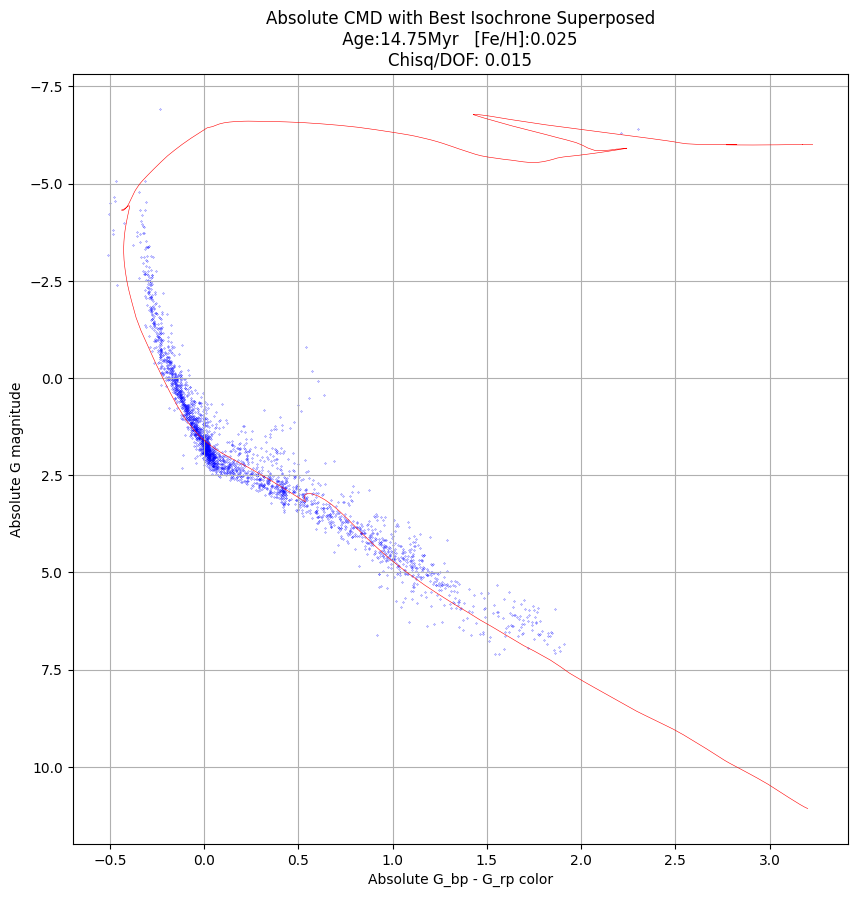

In [19]:
def plot_isochrone(myr, feh, color, linewidth=0.2):
    isochrone = get_isochrone(myr*u.Myr, feh)
    plt.plot(isochrone['bp_rp_color'].value, isochrone['g_abs_mag'].value, color=color, lw=linewidth)

plt.rcParams["figure.figsize"] = (10,10)
#plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
#plt.scatter(bp_rp_members, absmag_g_members, 0.07, color="blue")

plt.title(f"Absolute CMD with Best Isochrone Superposed\n Age:{ages[best_idx]:.2f}Myr   [Fe/H]:{metallicities[best_idx]:.3f} \nChisq/DOF: {chisqs[best_idx]:.3f}")
plt.ylabel("Absolute G magnitude")
plt.xlabel("Absolute G_bp - G_rp color")

plot_isochrone(ages[best_idx], metallicities[best_idx], 'red', linewidth=0.4)

#plt.scatter(bp_rp_ext_members, absmag_g_members, 0.07, color="green")
plt.scatter(bp_rp_ext_members, absmag_g_ext_members, 0.05, color="blue")
#plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
figure = plt.gcf()
axes = figure.gca()
axes.invert_yaxis()
plt.grid()
plt.savefig("../tex/figures/abscmd.png")
plt.show()

In [20]:
%%time
# Takes about 5 minutes to run this, but its checking 390 isochrones near where I expect the cluster to be based on Gaia photometry

# Now going to fit A

age = abs_mag_isochrone[0]
metallicity = abs_mag_isochrone[1]


distance_list = np.linspace(1900, 2600, 15)    # Values for distance in pc
extinction_list = np.linspace(1.0, 2.5, 26)  # Values for A_v extinction in mags

print(distance_list, np.round(extinction_list,decimals=3))

# Theory here is that just looking at the CMD, the really faint stars have two issues
# 1) They are spread out on the CMD, this could be due to them being:
#     a) more red and more affected by extinction, 
#     b) smaller and more likely to be outside the cluster center leading to variation in extinction
#     c) less likely to have properly resolved color by the telsecope
# 2) Misidentified as cluster members because they are in the vicinity, large in population
#
# Gaia's photometry handles this on a star-by-star basis with some complex algorithm; however
# I can just remove them and hopefully get a fit that is not degenerate
#
mod_mask = [(mag > 17) for mag in mag_g_members.compressed()]
mag_g_members_mod = np.ma.array(mag_g_members.compressed(), mask = mod_mask)
bp_rp_members_mod = np.ma.array(bp_rp_members.compressed(), mask = mod_mask)

chisqs = []
distances = []
extinctions = []
for distance in distance_list:
    print(f"\n{distance} pc chisq = ", end="")
    for extinction in extinction_list:
        #chisq = calc_chisq_isochrone((bp_rp_members, mag_g_members), get_isochrone(age*u.Myr, metallicity, distance, extinction))
        chisq = calc_chisq_isochrone((bp_rp_members_mod, mag_g_members_mod), get_isochrone(age*u.Myr, metallicity, distance, extinction))
        chisqs.append(chisq)
        distances.append(distance)
        extinctions.append(extinction)
        print(f"{chisq:.4f},", end="")
        #print("Age:", age, "Myr Metallicity:", metallicity, " [Fe/H] Chisq/dof:", chisq)

best_idx = np.argmin(chisqs)
apparent_mag_isochrone = (age, metallicity, distances[best_idx], extinctions[best_idx], chisqs[best_idx])

print(f"\n\nBest isochrone has Distance:{apparent_mag_isochrone[2]:.2f} pc Extinction: {apparent_mag_isochrone[3]:.2f} mag and reduced chisq: {apparent_mag_isochrone[4]:.6f}")        

[1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250. 2300. 2350. 2400. 2450.
 2500. 2550. 2600.] [1.   1.06 1.12 1.18 1.24 1.3  1.36 1.42 1.48 1.54 1.6  1.66 1.72 1.78
 1.84 1.9  1.96 2.02 2.08 2.14 2.2  2.26 2.32 2.38 2.44 2.5 ]

1900.0 pc chisq = 0.0394,0.0359,0.0329,0.0302,0.0278,0.0258,0.0239,0.0227,0.0219,0.0216,0.0218,0.0225,0.0236,0.0251,0.0270,0.0297,0.0329,0.0367,0.0410,0.0458,0.0510,0.0570,0.0636,0.0709,0.0788,0.0873,
1950.0 pc chisq = 0.0402,0.0365,0.0332,0.0302,0.0275,0.0250,0.0230,0.0216,0.0205,0.0200,0.0200,0.0204,0.0212,0.0223,0.0242,0.0267,0.0297,0.0334,0.0374,0.0419,0.0472,0.0530,0.0595,0.0666,0.0743,0.0829,
2000.0 pc chisq = 0.0415,0.0375,0.0339,0.0305,0.0274,0.0247,0.0226,0.0208,0.0196,0.0189,0.0185,0.0187,0.0191,0.0202,0.0220,0.0242,0.0271,0.0305,0.0343,0.0388,0.0439,0.0496,0.0559,0.0628,0.0705,0.0788,
2050.0 pc chisq = 0.0430,0.0388,0.0348,0.0311,0.0277,0.0250,0.0225,0.0206,0.0191,0.0181,0.0175,0.0173,0.0176,0.0186,0.0201,0.0222,0.0249,0.0280,0.0318,0.0361,0.0410,0.046

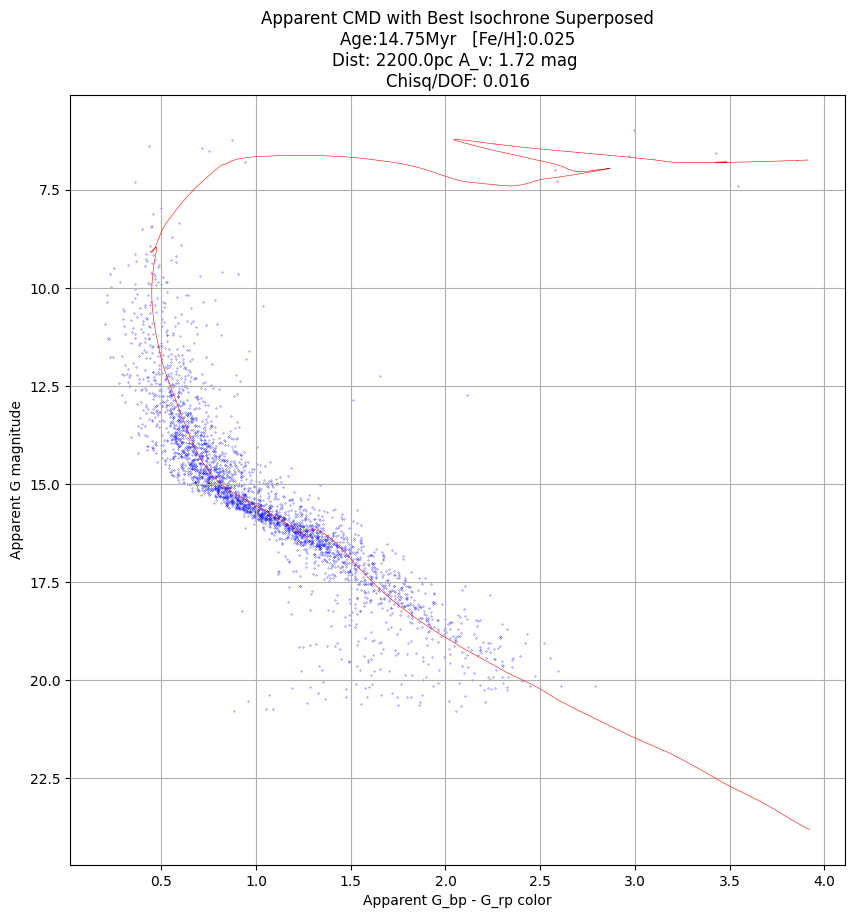

In [21]:
def plot_isochrone(myr, feh, distance, extinction, color, linewidth=0.2):
    isochrone = get_isochrone(myr*u.Myr, feh, distance, extinction )
    plt.plot(isochrone['bp_rp_color'].value, isochrone['g_abs_mag'].value, color=color, lw=linewidth)

plt.rcParams["figure.figsize"] = (10,10)
#plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
#plt.scatter(bp_rp_members, absmag_g_members, 0.07, color="blue")

plt.title(f"""Apparent CMD with Best Isochrone Superposed
Age:{age:.2f}Myr   [Fe/H]:{metallicity:.3f}
Dist: {distances[best_idx]}pc A_v: {extinctions[best_idx]:.2f} mag 
Chisq/DOF: {chisqs[best_idx]:.3f}""")
plt.ylabel("Apparent G magnitude")
plt.xlabel("Apparent G_bp - G_rp color")

plot_isochrone(age, metallicity, distances[best_idx], extinctions[best_idx], 'red', linewidth=0.4)
#plot_isochrone(age, metallicity, 2100, 1.8, 'blue', linewidth=0.4)
#plot_isochrone(age, metallicity, 2500, 1.933, 'green', linewidth=0.4)
#plot_isochrone(age, metallicity, 3000, 2.067, 'red', linewidth=0.4)

#plt.scatter(bp_rp_ext_members, absmag_g_members, 0.07, color="green")
plt.scatter(bp_rp_members, mag_g_members, 0.05, color="blue")
#plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
figure = plt.gcf()
axes = figure.gca()
axes.invert_yaxis()
plt.grid()
plt.savefig("../tex/figures/appcmd.png")
plt.show()

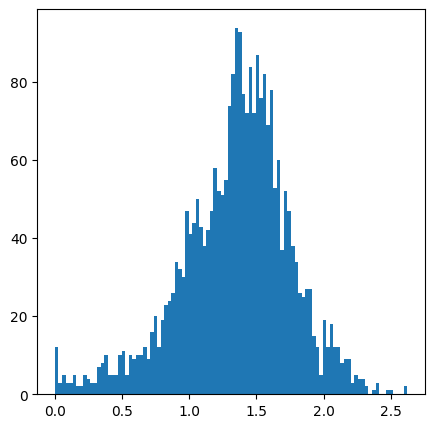

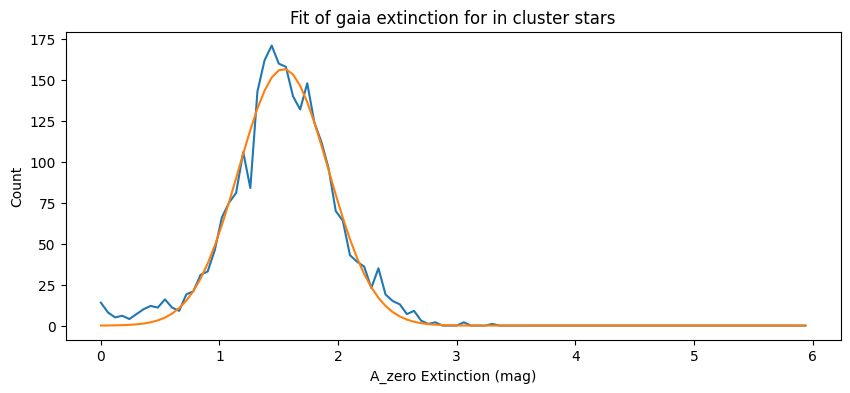

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    156.80741699340442 1.5398479845348805 0.3794152831851661


In [24]:
from astropy.modeling import models, fitting
azero_extinction_members = np.ma.array(r['azero_gspphot'], mask=np.logical_not(member_all))
ag_extinction_members = np.ma.array(r['ag_gspphot'], mask=np.logical_not(member_all))

#print(np.mean(g_band_extinction_members.compressed()))
#print(np.std(g_band_extinction_members.compressed()))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
plt.hist(ag_extinction_members.compressed(), bins=100)
plt.show()

#distdata = azero_extinction_members


fit = fitting.LevMarLSQFitter()

heights, bins = np.histogram(azero_extinction_members.compressed(), bins=100, range=(0,6))

gg_init = models.Gaussian1D(35, 1.5, 0.5)

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title("Fit of gaia extinction for in cluster stars")
plt.xlabel("A_zero Extinction (mag)")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
#plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
#plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.show()

print(fit.fit_info['message'])
print(fitted_gaussian)

-------

2961 7722.278384282187
2603 6539.138986036913


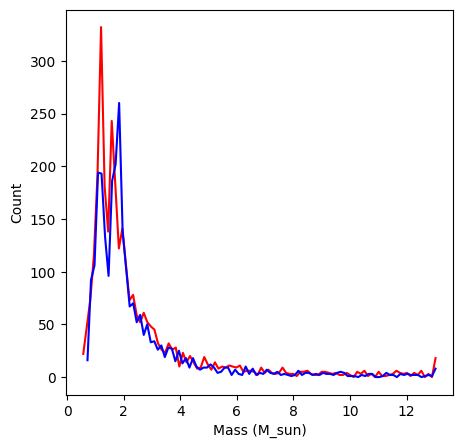

In [25]:
def calc_mass_from_isochrone(data, isochrone):
    
    data_color, data_mag = data
    iso_color = isochrone['bp_rp_color'].value
    iso_mag = isochrone['g_abs_mag'].value
    
    
    # We are pretending here that the individual color/mag points don't have error bars
    # So I'm treating this like an ordinary least squares fit
    masses = []
    for point_color, point_mag in zip(data_color.compressed(), data_mag.compressed()):
        # I'm using the nearest point *on* the isochrone, without doing any interpolation
        index = np.argmin((iso_color - point_color)**2 + (iso_mag - point_mag)**2)
        masses.append (isochrone['mass'][index].value)
        
    return masses

masses = calc_mass_from_isochrone((bp_rp_members, mag_g_members), get_isochrone(apparent_mag_isochrone[0]*u.Myr, apparent_mag_isochrone[1], apparent_mag_isochrone[2], apparent_mag_isochrone[3]))
masses_abs = calc_mass_from_isochrone((bp_rp_ext_members, absmag_g_ext_members), get_isochrone(abs_mag_isochrone[0]*u.Myr, abs_mag_isochrone[1]))

print(len(masses), np.sum(masses))
print(len(masses_abs), np.sum(masses_abs))

plt.rcParams["figure.figsize"] = (5,5)
heights, bins = np.histogram(masses, bins=100)
plt.plot(bins[:-1], heights, color='red')
heights, bins = np.histogram(masses_abs, bins=100)
plt.plot(bins[:-1], heights, color='blue')
plt.ylabel("Count")
plt.xlabel("Mass (M_sun)")
plt.savefig("../tex/figures/massdist.png")
plt.show()

#plt.rcParams["figure.figsize"] = (5,5)
#plt.hist(masses_abs, bins=100)
#plt.ylabel("Count")
#plt.xlabel("Mass (M_sun)")
#plt.savefig("../tex/figures/massdist_abs.png")
#plt.show()

--------------

In [14]:
a= np.ma.array([1,np.nan,2], mask=[True, False, False])
print(np.isnan(a.compressed()))

[ True False]


In [15]:
a = np.array([2,1,2,3])
np.argmin(a)


1

In [16]:
#Write a function
# Input is log10(age), metalicity, distance, extinction
# Output is points at all valid EEPS (those that don't return nan) in an astropy table with colums 'G' and 'BP-RP' both in mags
# EEPS can possibly run from 0 to 1710
import astropy.units as u
import bcutil


def get_isochrone2(age, metallicity):
    from isochrones.mist import MIST_Isochrone
    from astropy import table
    mist = MIST_Isochrone()
    
    log_age = np.log10(age.to(u.yr).value)
    
    
    mass_array = []
    Teff_array = []
    Mbol_array = []
    logg_array = []
    feh_array = []
    ebv_array = []
    
    for eep in range(0, 1710):
        mass, Teff, Mbol, logg, feh = mist.interp_value([eep, log_age, metallicity], ['mass', 'Teff', 'Mbol', 'logg', 'feh'])
        
        if np.any(np.isnan([mass, Teff, Mbol, logg, feh])):
            continue
        mass_array.append(mass)
        Teff_array.append(Teff)
        Mbol_array.append(Mbol)
        logg_array.append(logg)
        feh_array.append(feh)
        ebv_array.append(0.0)
    
    #print(len(Teff_array), len(logg_array), len(feh_array))
    bolometric_corrections = bcutil.bcstar(
        ['']*len(Teff_array),
        np.array(Teff_array), 
        np.array(logg_array), 
        np.array(feh_array), 
        np.array(ebv_array), filters='G3 BP3 RP3', retarr=True)
    
    #print(bolometric_corrections)
    
    mask = np.isnan(bolometric_corrections[:,0])
    
    g_corr_array = np.ma.array(bolometric_corrections[:,0], mask=mask)
    #print(g_corr_array.compressed())
    
    bp_corr_array = np.ma.array(bolometric_corrections[:,1], mask=mask)
    #print(bp_corr_array)
    
    rp_corr_array = np.ma.array(bolometric_corrections[:,2], mask=mask)
    #print(rp_corr_array)
    
    Mbol_array_masked = np.ma.array(Mbol_array, mask=mask)
    mass_array_masked = np.ma.array(mass_array, mask=mask)
    Teff_array_masked = np.ma.array(Teff_array, mask=mask)
    
    # Derive G mags from Mbol 
    g_mag_arr = Mbol_array_masked.compressed() - g_corr_array.compressed()
    
    # Then derive BP-RP color with those two columns
    bp_rp_arr = rp_corr_array.compressed() - bp_corr_array.compressed()
    
    # Then knit it all together into an astropy table
        
    return table.QTable([Mbol_array_masked.compressed(), mass_array_masked.compressed(), Teff_array_masked.compressed(), g_mag_arr, bp_rp_arr], names=('mbol','mass','Teff','g_mag', 'bp_rp'))
    
#get_isochrone2(12*u.Myr, -0.6)

In [17]:
print(dist_center, azero_extinction)

def plot_isochrone(myr, feh, color, linewidth=0.2):
    isochrone = get_isochrone(myr*u.Myr, feh, dist_center*1000, azero_extinction)
    plt.plot(isochrone['bp_rp_color'], isochrone['g_abs_mag'], color=color, lw=linewidth)

def plot_isochrone2(myr, feh, color, linewidth=0.2):
    isochrone = get_isochrone2(myr*u.Myr, feh)
    plt.plot(isochrone['bp_rp'], isochrone['g_mag'], color=color, lw=linewidth)

plt.rcParams["figure.figsize"] = (10,10)
#plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
#plt.scatter(bp_rp_members, absmag_g_members, 0.07, color="blue")

plot_isochrone2(14, -1.7, 'blue')
plot_isochrone(14, -1.7, 'red')
#plot_isochrone(14, -1.7, 'red')

#plt.scatter(bp_rp_members, absmag_g_ext_members, 0.07, color="green")
plt.scatter(bp_rp_ext_members, absmag_g_ext_members, 0.07, color="blue")
plt.scatter(bp_rp_members, mag_g_members, 0.07, color="red")
figure = plt.gcf()
axes = figure.gca()
axes.invert_yaxis()
plt.show()

NameError: name 'azero_extinction' is not defined

In [ ]:
#next try ezpadova and a panstars http://stev.oapd.inaf.it/cgi-bin/cmd isochrone

In [ ]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid

bc_grid = MISTBolometricCorrectionGrid(['J', 'H', 'K', 'G', 'BP', 'RP', 'g', 'r', 'i'])
bc_grid.get_band('G'), bc_grid.get_band('g')

In [ ]:
z= 0.01
np.log10(z/(1-z))

In [ ]:

from isochrones.mist import MIST_Isochrone

mist = MIST_Isochrone()

pars = [353, 9.78, -1.24]  # eep, log(age), feh
mist.interp_value(pars, ['mass', 'radius', 'Teff'])
mist.interp_mag(pars + [200, 0.11], ['K', 'BP', 'RP'])  # Returns Teff, logg, feh, mags

In [ ]:
from isochrones.mist import MISTIsochroneGrid
grid = MISTIsochroneGrid()
print(len(grid.df))
#grid.df.xs((9.0, 0.0), level=(0,1)).head(10)  # Just the first few rows
grid.df.head(10)

In [ ]:
import astropy.units as u
cluster_age = np.array([12.5, 14])*u.Myr
cluster_age
cluster_log_age = np.log10(cluster_age.to(u.yr).value)
cluster_log_age



In [ ]:
from isochrones.mist import MISTIsochroneGrid
grid = MISTIsochroneGrid()
print(grid.df.index)
print(np.unique(grid.df.index.get_level_values('log10_isochrone_age_yr').values))
print(np.unique(grid.df.index.get_level_values('feh').values))
print(np.unique(grid.df.index.get_level_values('EEP').values))


In [ ]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid

bc_grid = MISTBolometricCorrectionGrid(['G', 'BP', 'RP'])

bc_grid.interp.index_names




In [ ]:
bc_grid.df.head()

In [ ]:
np.log10(13000000)